### Notebook for the label transfer of Healthy Human Reference to mouse ACM heart (merged Pkp2+Ttn dataset) using `scANVI`

#### Environment: scANVI

- **Developed by:** Carlos Talavera-López Ph.D
- **Modified by:** Alexandra Cirnu
- **Würzburg Institute for Systems Immunology & Julius-Maximilian-Universität Würzburg**
- **Date of creation:** 230918
- **Date of modification:** 240223

Yoshida PBMC dataset (subsetted to contain only healthy donors) and healthy human heart leucocytes (from Human cell atlas) were combined to generate a reference for seed labelling

### Import required modules

In [124]:
import scvi
import torch
import anndata
import warnings
import numpy as np
import scanpy as sc
import pandas as pd
import plotnine as p
from pywaffle import Waffle
import matplotlib.pyplot as plt
#from scib_metrics.benchmark import Benchmarker

### Set up working environment

In [125]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.10.5.post1
scanpy      1.9.8
-----
PIL                 9.4.0
absl                NA
array_api_compat    1.4.1
asttokens           NA
attr                23.2.0
chex                0.1.85
colorama            0.4.6
comm                0.2.1
contextlib2         NA
cycler              0.12.1
cython_runtime      NA
dateutil            2.8.2
debugpy             1.8.1
decorator           5.1.1
docrep              0.3.2
etils               1.7.0
exceptiongroup      1.2.0
executing           2.0.1
flax                0.8.1
fsspec              2024.2.0
gmpy2               2.1.2
h5py                3.10.0
importlib_resources NA
ipykernel           6.29.2
ipywidgets          8.1.2
jax                 0.4.24
jaxlib              0.4.24
jedi                0.19.1
joblib              1.3.2
kiwisolver          1.4.5
lightning           2.1.4
lightning_utilities 0.10.1
llvmlite            0.42.0
matplotlib          3.8.3
matplotlib_inline   0.1.6
mizani              0.9.3
ml_collecti

In [126]:
def X_is_raw(adata): return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis=0))

In [127]:
torch.set_float32_matmul_precision('high')

In [128]:
warnings.simplefilter(action = 'ignore')
scvi.settings.seed = 1712
%config InlineBackend.print_figure_kwargs = {'facecolor' : "w"}
%config InlineBackend.figure_format = 'retina'

Seed set to 1712


In [129]:
arches_params = dict(
    use_layer_norm = "both",
    use_batch_norm = "none",
    encode_covariates = True,
    dropout_rate = 0.2,
    n_layers = 2,
)

### Read in Healthy data

In [130]:
reference = sc.read_h5ad('/home/acirnu/data/ACM_cardiac_leuco/Reference_data/Merged_healthy_reference_PBMC_Heart_ac240222.raw.h5ad')
reference

AnnData object with n_obs × n_vars = 214552 × 33514
    obs: 'COVID_status', 'annotation_broad', 'annotation_detailed', 'n_counts', 'n_genes', 'age_group', 'donor', 'sample', 'cell_source', 'cell_states', 'gender', 'NRP', 'region', 'scNym', 'scNym_confidence', 'seed_labels'
    var: 'name-Yoshida'

In [131]:
X_is_raw(reference)

True

In [132]:
reference.obs['seed_labels'].value_counts()

seed_labels
CD4+T           53575
CD8+T           42060
Monocytes       35482
B_cells         27327
NK              25499
Macrophages     14519
Treg             6434
DC               2259
NKT              1683
Mast_cells       1543
Hematopoetic     1534
pDC               706
Platelets         626
Doublets          623
Plasma_cells      352
ILC               199
Neutrophils       121
Baso_Eosino        10
Name: count, dtype: int64

In [133]:
reference.obs['seed_labels'].cat.categories

Index(['B_cells', 'Baso_Eosino', 'CD4+T', 'CD8+T', 'DC', 'Doublets',
       'Hematopoetic', 'ILC', 'Macrophages', 'Mast_cells', 'Monocytes', 'NK',
       'NKT', 'Neutrophils', 'Plasma_cells', 'Platelets', 'Treg', 'pDC'],
      dtype='object')

In [134]:
reference_macros = reference[reference.obs["seed_labels"].isin(["Macrophages"]), :]
reference_macros

View of AnnData object with n_obs × n_vars = 14519 × 33514
    obs: 'COVID_status', 'annotation_broad', 'annotation_detailed', 'n_counts', 'n_genes', 'age_group', 'donor', 'sample', 'cell_source', 'cell_states', 'gender', 'NRP', 'region', 'scNym', 'scNym_confidence', 'seed_labels'
    var: 'name-Yoshida'

### Subset populations of interest

In [135]:
reference_macros = reference_macros[~reference_macros.obs['seed_labels'].isin(['nan'])]              # = filter out not assigned cells
reference_macros.obs['seed_labels'].value_counts()

seed_labels
Macrophages    14519
Name: count, dtype: int64

In [136]:
sc.pp.filter_cells(reference_macros, min_genes = 200)              #to remove empty cells from table
sc.pp.filter_cells(reference_macros, min_counts = 100)

### Read in other query - Now we read in the file of the already seed labeled Pkp2+Ttn Ctrls - in the next step we subset only macrophages

In [137]:
query = sc.read_h5ad('/home/acirnu/data/ACM_cardiac_leuco/Reference_data/Merge+Subset_Ctrls_scANVI_cellstates_from_healthy_reference_ac240222.raw.h5ad')
query

AnnData object with n_obs × n_vars = 7847 × 32285
    obs: 'n_counts', 'n_genes', 'donor', 'sample', 'cell_source', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts-A1', 'mean_counts-A1', 'pct_dropout_by_counts-A1', 'total_counts-A1', 'n_cells_by_counts-A2', 'mean_counts-A2', 'pct_dropout_by_counts-A2', 'total_counts-A2', 'n_cells_by_counts-A3', 'mean_counts-A3', 'pct_dropout_by_counts-A3', 'total_counts-A3', 'n_cells_by_counts-A4', 'mean_counts-A4', 'pct_dropout_by_counts-A4', 'total_counts-A4', 'n_cells_by_counts-B1', 'mean_counts-B1', 'pct_dropout_by_counts-B1', 'total_counts-B1', 'n_cells_by_counts-B2', 'mean_counts-B2', 'pct_dropout_by_counts-B2', 't

In [138]:
X_is_raw(query)

True

In [139]:
query_macros = query[query.obs["seed_labels"].isin(["Macrophages"]), :]
query_macros

View of AnnData object with n_obs × n_vars = 0 × 32285
    obs: 'n_counts', 'n_genes', 'donor', 'sample', 'cell_source', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts-A1', 'mean_counts-A1', 'pct_dropout_by_counts-A1', 'total_counts-A1', 'n_cells_by_counts-A2', 'mean_counts-A2', 'pct_dropout_by_counts-A2', 'total_counts-A2', 'n_cells_by_counts-A3', 'mean_counts-A3', 'pct_dropout_by_counts-A3', 'total_counts-A3', 'n_cells_by_counts-A4', 'mean_counts-A4', 'pct_dropout_by_counts-A4', 'total_counts-A4', 'n_cells_by_counts-B1', 'mean_counts-B1', 'pct_dropout_by_counts-B1', 'total_counts-B1', 'n_cells_by_counts-B2', 'mean_counts-B2', 'pct_dropout_by_counts-B2

In [140]:
sc.pp.filter_cells(query, min_genes = 200)
sc.pp.filter_cells(query, min_counts = 100)

### Change gene symbols for label transfer

In [141]:
query_macros.var_names = [gene_name.upper() for gene_name in query_macros.var_names]
query_macros.var_names

Index(['XKR4', 'GM1992', 'GM19938', 'GM37381', 'RP1', 'SOX17', 'GM37587',
       'GM37323', 'MRPL15', 'LYPLA1',
       ...
       'GM16367', 'AC163611.1', 'AC163611.2', 'AC140365.1', 'AC124606.2',
       'AC124606.1', 'AC133095.2', 'AC133095.1', 'AC234645.1', 'AC149090.1'],
      dtype='object', length=32285)

In [142]:
adata = reference_macros.concatenate(query_macros, batch_key = 'batch', batch_categories = ['reference_macros', 'query_macros'], join = 'inner')                #merge to one adata object
adata

AnnData object with n_obs × n_vars = 14519 × 16209
    obs: 'COVID_status', 'annotation_broad', 'annotation_detailed', 'n_counts', 'n_genes', 'age_group', 'donor', 'sample', 'cell_source', 'cell_states', 'gender', 'NRP', 'region', 'scNym', 'scNym_confidence', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids-query_macros', 'feature_types-query_macros', 'mt-query_macros', 'ribo-query_macros', 'n_cells_by_counts-A1-query_macros', 'mean_counts-A1-query_macros', 'pct_dropout_by_counts-A1-query_macros', 'total_counts-A1-query_macros', 'n_cells_by_counts-A2-query_macros', 'mean_counts-A2-query_macros', 'pct_dropout_by_counts-A2-query_macros', 'total_counts-A2-query_macros', 'n_cells_by_counts-A3-query_macros', 'm

In [143]:
adata.obs['seed_labels'] = adata.obs['seed_labels'].astype('category')
adata.obs['seed_labels'].value_counts()

seed_labels
Macrophages    14519
Name: count, dtype: int64

In [144]:
adata.obs['batch'].value_counts()

batch
reference_macros    14519
query_macros            0
Name: count, dtype: int64

### Select HVGs

In [145]:
adata.obs['donor'] = adata.obs['donor'].astype('str') 
adata.obs['donor'].value_counts()

donor
D6     3008
D11    1918
D7     1680
D2     1304
D3     1304
D4      821
H7      798
D5      796
H2      736
H4      514
H3      470
H5      421
H6      416
D1      333
Name: count, dtype: int64

In [146]:
adata_raw = adata.copy()
adata.layers['counts'] = adata.X.copy()

sc.pp.highly_variable_genes(
    adata,
    flavor = "seurat_v3",
    n_top_genes = 2000,                     #only 2000 because we have only macrophages
    layer = "counts",
    batch_key = "donor",
    subset = True,
    span = 1
    )

adata

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


AnnData object with n_obs × n_vars = 14519 × 2000
    obs: 'COVID_status', 'annotation_broad', 'annotation_detailed', 'n_counts', 'n_genes', 'age_group', 'donor', 'sample', 'cell_source', 'cell_states', 'gender', 'NRP', 'region', 'scNym', 'scNym_confidence', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids-query_macros', 'feature_types-query_macros', 'mt-query_macros', 'ribo-query_macros', 'n_cells_by_counts-A1-query_macros', 'mean_counts-A1-query_macros', 'pct_dropout_by_counts-A1-query_macros', 'total_counts-A1-query_macros', 'n_cells_by_counts-A2-query_macros', 'mean_counts-A2-query_macros', 'pct_dropout_by_counts-A2-query_macros', 'total_counts-A2-query_macros', 'n_cells_by_counts-A3-query_macros', 'me

### Transfer of annotation with scANVI

In [147]:
scvi.model.SCVI.setup_anndata(adata, 
                              batch_key = 'donor', 
                              labels_key = 'seed_labels',
                              layer = 'counts',
                              categorical_covariate_keys = ['donor', 'cell_source'])

In [148]:
scvi_model = scvi.model.SCVI(adata, 
                             n_latent = 50, 
                             n_layers = 3, 
                             dispersion = 'gene-batch', 
                             gene_likelihood = 'nb')

In [149]:
scvi_model.train(46, 
                 check_val_every_n_epoch = 1, 
                 enable_progress_bar = True,
                 accelerator = "gpu",
                 devices = [1]                                        
                 )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 46/46: 100%|██████████| 46/46 [00:28<00:00,  1.60it/s, v_num=1, train_loss_step=640, train_loss_epoch=574]  

`Trainer.fit` stopped: `max_epochs=46` reached.


Epoch 46/46: 100%|██████████| 46/46 [00:28<00:00,  1.61it/s, v_num=1, train_loss_step=640, train_loss_epoch=574]


### Evaluate model performance a la _Sevensson_

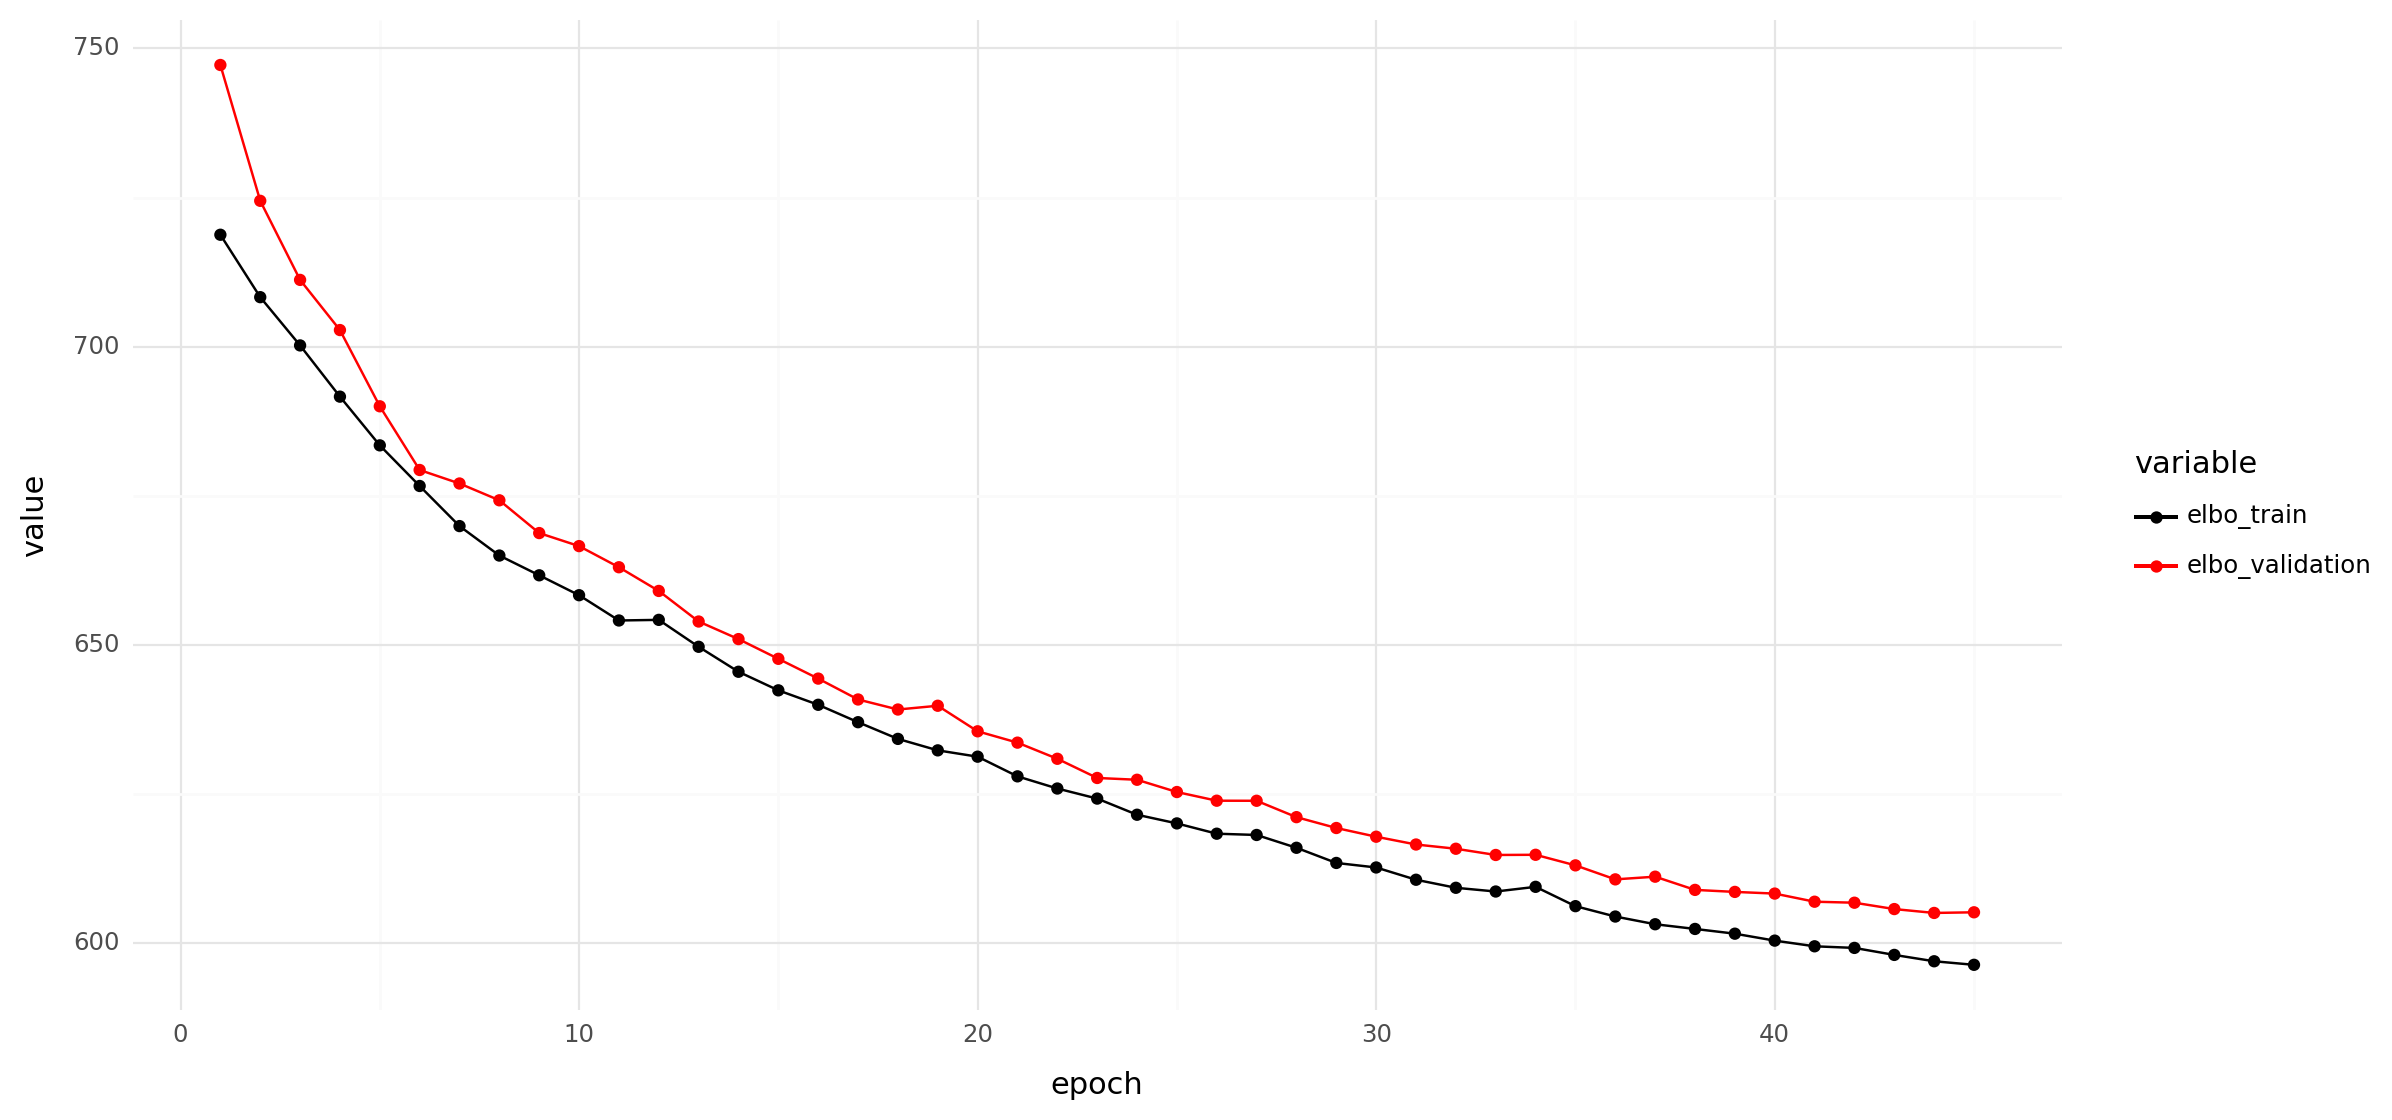

In [150]:
history_df = (
    scvi_model.history['elbo_train'].astype(float)
    .join(scvi_model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

p_.save('fig1.png', dpi = 300)

print(p_)

### Label transfer with `scANVI` 

In [122]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(scvi_model, 'Unknown')

In [123]:
scanvi_model.train(50, 
                   check_val_every_n_epoch = 1, 
                   enable_progress_bar = True,
                   accelerator = "gpu",
                   devices = [1]                            
)

INFO     Training for 50 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 1/50:   0%|          | 0/50 [00:00<?, ?it/s]

ValueError: Expected argument `num_classes` to be an integer larger than 1, but got 1

### Evaluate model performance a la Svensson

In [ ]:
history_df = (
    scanvi_model.history['elbo_train'].astype(float)
    .join(scanvi_model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

p_.save('scANVI_14epochs.png', dpi = 300)

print(p_)

In [ ]:
adata.obs["C_scANVI"] = scanvi_model.predict(adata)

- Extract latent representation

In [ ]:
adata.obsm["X_scANVI"] = scanvi_model.get_latent_representation(adata)

- Visualise corrected dataset

In [ ]:
sc.pp.neighbors(adata, use_rep = "X_scANVI", n_neighbors = 50, metric = 'minkowski')
sc.tl.umap(adata, min_dist = 0.3, spread = 4, random_state = 1712)

In [ ]:
sc.pl.umap(adata, frameon = False, color = ['C_scANVI', 'seed_labels', 'condition', 'batch'], size = 1, legend_fontsize = 5, ncols = 1)

### Export annotated object

In [ ]:
adata_export_merged = anndata.AnnData(X = adata_raw.X, var = adata_raw.var, obs = adata.obs)
adata_export_merged

In [ ]:
adata_export = adata_export_merged[adata_export_merged.obs['batch'].isin(['query'])]
adata_export

### Add new gene symbols

In [ ]:
query_export = anndata.AnnData(X = query.X, var = query.var, obs = adata_export.obs)
query_export

### Revert gene symbols

In [ ]:
query_export.var_names = [gene_name.capitalize() for gene_name in query_export.var_names]
query_export.var_names

In [ ]:
query_export.obs['C_scANVI'].value_counts()

In [ ]:
query_export

In [ ]:
query_export.obs

In [ ]:
query_export.write('/home/acirnu/data/ACM_cardiac_leuco/Reference_data/Merge+Subset_Ctrls_scANVI_cellstates_from_healthy_reference_ac240222.raw.h5ad')